In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Data location. Please edit.

# A tfrecord containing tf.Example protos as downloaded from the Waymo Open
# Dataset (motion) webpage.

# Replace this path with your own tfrecords.
DATASET_FOLDER = './data'

# TFRecord dataset.
TRAIN_FILES = f'{DATASET_FOLDER}/tf_example/training/training_tfexample.tfrecord*'
# TRAIN_FILES = 'training.tfrecord*'
VAL_FILES = f'{DATASET_FOLDER}/tf_example/validation/validation_tfexample.tfrecord*'
TEST_FILES = f'{DATASET_FOLDER}/tf_example/testing/testing_tfexample.tfrecord*'


# Text files containing validation and test scenario IDs for this challenge.
VAL_SCENARIO_IDS_FILE = f'{DATASET_FOLDER}/occupancy_flow_challenge/validation_scenario_ids.txt'
TEST_SCENARIO_IDS_FILE = f'{DATASET_FOLDER}/occupancy_flow_challenge/testing_scenario_ids.txt'

import pathlib
import os
from typing import Dict, List, Mapping, Optional, Sequence, Tuple, Union
import uuid
import zlib

from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from preprocess_tools import *
from tqdm import tqdm
# import tensorflow_graphics.image.transformer as tfg_transformer

from google.protobuf import text_format
from waymo_open_dataset.protos import occupancy_flow_metrics_pb2
from waymo_open_dataset.protos import occupancy_flow_submission_pb2
from waymo_open_dataset.protos import scenario_pb2
# from waymo_open_dataset.utils import occupancy_flow_metrics

2022-04-16 20:32:32.113220: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [8]:
raw_dataset = tf.data.TFRecordDataset(['/GPFS/rhome/ziwang/projects/occupancy_flow/dataset/training/training.tfrecord-00000-of-01000'])
for raw_record_index, raw_record in enumerate(raw_dataset):
    proto_string = raw_record.numpy()
    proto = scenario_pb2.Scenario()
    proto.ParseFromString(proto_string)
    scene_id = raw_record_index
    if raw_record_index == 1:
        break


In [9]:
inputs = read_data_proto(proto)
inputs_numpy = {k:np.array(v, dtype=object) for k, v in inputs.items()}

In [34]:
images = visualize_all_agents_smooth(inputs_numpy)

In [22]:
for idx in tqdm(range(len(images))):
    cv2.imwrite("./figs/ori_img/{}.png".format(str(idx)), images[idx])
    
generate_vid_from_pic("./figs/ori_img/", "ori", 5)

100%|██████████| 91/91 [00:05<00:00, 18.17it/s]


Done


In [10]:
config = occupancy_flow_metrics_pb2.OccupancyFlowTaskConfig()
config_text = """
num_past_steps: 10
num_future_steps: 80
num_waypoints: 8
cumulative_waypoints: false
normalize_sdc_yaw: true
grid_height_cells: 256
grid_width_cells: 256
sdc_y_in_grid: 192
sdc_x_in_grid: 128
pixels_per_meter: 3.2
agent_points_per_side_length: 48
agent_points_per_side_width: 16
"""
text_format.Parse(config_text, config)
config

num_past_steps: 10
num_future_steps: 80
num_waypoints: 8
cumulative_waypoints: false
grid_height_cells: 256
grid_width_cells: 256
sdc_y_in_grid: 192
sdc_x_in_grid: 128
pixels_per_meter: 3.200000047683716
agent_points_per_side_length: 48
agent_points_per_side_width: 16
normalize_sdc_yaw: true

In [7]:
# inputs_batch = {k: np.expand_dims(np.array(v, dtype = object), 0) for k, v in inputs.items()}
inputs_batch = {}
for k, v in inputs.items():
    if k == 'scenario/id':
        inputs_batch[k] = v
        continue
    inputs_batch[k] = np.expand_dims(np.array(v, dtype = np.float32), 0)
    
import pickle 
with open('/GPFS/rhome/ziwang/projects/occupancy_flow/dataset/train_preprocessed_data/{}.pkl'.format(scene_id), 'wb') as fp:
    pickle.dump(inputs_batch, fp)
    
inputs_batch = add_sdc_fields(inputs_batch)
# for k, v in inputs_batch.items():
#     print(k, ':', v.shape)


In [8]:
inputs_batch = numpy_to_tf(inputs_batch)

In [9]:
timestep_grids = create_ground_truth_timestep_grids(
    inputs=inputs_batch, config=config)
print(timestep_grids.vehicles.current_occupancy.shape)
print(timestep_grids.vehicles.past_occupancy.shape)
print(timestep_grids.vehicles.future_occluded_occupancy.shape)
print(timestep_grids.vehicles.future_observed_occupancy.shape)
print(timestep_grids.vehicles.all_flow.shape)

(1, 256, 256, 1)
(1, 256, 256, 10)
(1, 256, 256, 80)
(1, 256, 256, 80)
(1, 256, 256, 81, 2)


In [10]:
for idx in tqdm(range(81)):
    img = flow_rgb_image_per_step(timestep_grids.vehicles.all_flow[:,:,:,idx,:][0])
    cv2.imwrite("/GPFS/rhome/ziwang/projects/occupancy_flow/vis/figs_preprocess/flow_img_step/{}.png".format(str(idx)), np.array(img)*255)
    
# generate_vid_from_pic("./figs/flow_img_step/", "flow_per_step", 5)

100%|██████████| 81/81 [00:03<00:00, 21.54it/s]


In [11]:
def generate_img_from_occupancy_grid(grid, color = 'r'):
  img = deepcopy(grid)
  idx = np.where(np.array(img))
  img = img[..., tf.newaxis]
  ones = tf.ones_like(img)
  fig = np.array(tf.concat([ones, ones, ones], axis=-1))*255
  if color == 'r':
    fig[idx] = np.array([0, 0, 255])
  if color == 'b':
    fig[idx] = np.array([255, 0, 0])
  
  return fig

In [12]:
for idx in tqdm(range(0, 10)):
    img = timestep_grids.vehicles.past_occupancy[0, :, :, idx]
    # print(generate_img_from_occupancy_grid(img).shape)
    cv2.imwrite("/GPFS/rhome/ziwang/projects/occupancy_flow/vis/figs_preprocess/occupancy_img_step/{}.png".format(str(idx)), generate_img_from_occupancy_grid(img))
    
img = timestep_grids.vehicles.current_occupancy[0, :, :, 0]
cv2.imwrite("/GPFS/rhome/ziwang/projects/occupancy_flow/vis/figs_preprocess/occupancy_img_step/10.png", generate_img_from_occupancy_grid(img))

for i, idx in tqdm(enumerate(range(11, 91))):
    img = timestep_grids.vehicles.future_observed_occupancy[0, :, :, i]
    cv2.imwrite("/GPFS/rhome/ziwang/projects/occupancy_flow/vis/figs_preprocess/occupancy_img_step/{}.png".format(str(idx)), generate_img_from_occupancy_grid(img))
    
# generate_vid_from_pic("./figs/occupancy_img_step/", "occupancy_per_step", 5)

100%|██████████| 10/10 [00:00<00:00, 28.76it/s]
80it [00:00, 132.11it/s]


In [15]:
for i, idx in tqdm(enumerate(range(11, 91))):
    img_observed = timestep_grids.vehicles.future_observed_occupancy[0, :, :, i]
    img_occluded = timestep_grids.vehicles.future_occluded_occupancy[0, :, :, i]
    img_1 = generate_img_from_occupancy_grid(img_observed, 'r')
    img_2 = generate_img_from_occupancy_grid(img_occluded, 'b')
    img = (img_1 + img_2) / 2
    cv2.imwrite("./figs/occluded_img_step/{}.png".format(str(idx)), img)
    
# generate_vid_from_pic("./figs/occluded_img_step/", "occluded_per_step", 5)

80it [00:01, 78.68it/s]


In [13]:
true_waypoints = create_ground_truth_waypoint_grids(
    timestep_grids=timestep_grids, config=config)
print(len(true_waypoints.vehicles.observed_occupancy))
print(true_waypoints.vehicles.occluded_occupancy[0].shape)
print(true_waypoints.vehicles.flow[0].shape)

save_file = {}
observed = []
occluded = []
flow = []
flow_origin_occupancy = []

for i in range(len(true_waypoints.vehicles.observed_occupancy)):
    observed.append(np.expand_dims(np.array(true_waypoints.vehicles.observed_occupancy[i], dtype = np.float), -1))
    occluded.append(np.expand_dims(np.array(true_waypoints.vehicles.occluded_occupancy[i], dtype = np.float), -1))
    flow.append(np.expand_dims(np.array(true_waypoints.vehicles.flow[i], dtype = np.float), -1))
    flow_origin_occupancy.append(np.expand_dims(np.array(true_waypoints.vehicles.flow_origin_occupancy[i], dtype = np.float), -1))
    
save_file["observed"] = np.concatenate(observed, -1)
save_file["occluded"] = np.concatenate(occluded, -1)
save_file["flow"] = np.concatenate(flow, -1)
save_file["flow_origin_occupancy"] = np.concatenate(flow_origin_occupancy, -1)

import pickle
with open('/GPFS/rhome/ziwang/projects/occupancy_flow/dataset/training_gt/{}.pkl'.format(scene_id), 'wb') as fp:
    pickle.dump(save_file, fp)

8
(1, 256, 256, 1)
(1, 256, 256, 2)


In [16]:
with open('/GPFS/rhome/ziwang/projects/occupancy_flow/dataset/training_gt/0.pkl', 'rb') as f:
    data = pickle.load(f)
    
data['flow'].shape

(1, 256, 256, 2, 8)

In [14]:
vis_grids = create_ground_truth_vis_grids(
    inputs=inputs_batch, timestep_grids=timestep_grids, config=config)
print(vis_grids.roadgraph.shape)
print(vis_grids.agent_trails.shape)

(1, 256, 256, 1)
(1, 256, 256, 1)


In [31]:
# Visualize waypoint 4 out of 8.
k = 3
observed_occupancy_grids = true_waypoints.get_observed_occupancy_at_waypoint(k)
observed_occupancy_rgb = occupancy_rgb_image(
    agent_grids=observed_occupancy_grids,
    roadgraph_image=vis_grids.roadgraph,
)

In [32]:
# plt.imshow(observed_occupancy_rgb[0])
# print(observed_occupancy_rgb[0].shape)
for idx in tqdm(range(8)):
    observed_occupancy_grids = true_waypoints.get_observed_occupancy_at_waypoint(idx)
    observed_occupancy_rgb = occupancy_rgb_image(agent_grids=observed_occupancy_grids,roadgraph_image=vis_grids.roadgraph,)
    cv2.imwrite("./figs/occupancy_img_accumulate/{}.png".format(str(idx)), np.array(observed_occupancy_rgb[0])*255)

generate_vid_from_pic("./figs/occupancy_img_accumulate/", "occupancy_accumulate", 1)

100%|██████████| 8/8 [00:00<00:00, 54.12it/s]

Done


In [33]:
occluded_occupancy_grids = true_waypoints.get_occluded_occupancy_at_waypoint(k)
occluded_occupancy_rgb = occupancy_rgb_image(
    agent_grids=occluded_occupancy_grids,
    roadgraph_image=vis_grids.roadgraph,
)

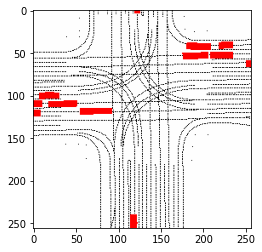

In [34]:
plt.imshow(occluded_occupancy_rgb[0])

In [35]:
flow_rgb = flow_rgb_image(
    flow=true_waypoints.vehicles.flow[k],
    roadgraph_image=vis_grids.roadgraph,
    agent_trails=vis_grids.agent_trails,
)

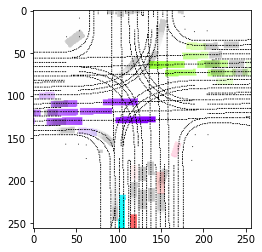

In [36]:
plt.imshow(flow_rgb[0])

In [37]:
for idx in tqdm(range(8)):
    flow_rgb = flow_rgb_image(flow=true_waypoints.vehicles.flow[idx],roadgraph_image=vis_grids.roadgraph,agent_trails=vis_grids.agent_trails,)
    cv2.imwrite("./figs/flow_img_accumulate/{}.png".format(str(idx)), np.array(flow_rgb[0])*255)

generate_vid_from_pic("./figs/flow_img_accumulate/", "flow_accumulate", 1)

100%|██████████| 8/8 [00:00<00:00, 65.87it/s]

Done
